In [1]:
import polars as pl
from plotnine import *

In [3]:
# cat shotgun_sra_20231208/* |jq -r '[.acc,.releasedate,.mbases,.organism] |@csv' |pigz >sra_metadata/sra_metadata_20230915.some_columns.csv.gz
df = pl.read_csv('sra_metadata/sra_metadata_20231208.some_columns.csv.gz', has_header=False)
df.columns = ['acc','releasedate','mbases','organism']
df[:4]

acc,releasedate,mbases,organism
str,str,i64,str
"""SRR10617032""","""2020-06-15T00:…",128,"""human metageno…"
"""SRR21134550""","""2023-08-14T00:…",15464,"""bovine gut met…"
"""SRR23801714""","""2023-03-10T00:…",17725,"""human gut meta…"
"""SRR26803262""","""2023-11-13T00:…",7119,"""feces metageno…"


In [4]:
df = df.with_columns(pl.col('releasedate').str.slice(0,10).str.to_date("%Y-%m-%d"))
df[:4]

acc,releasedate,mbases,organism
str,date,i64,str
"""SRR10617032""",2020-06-15,128,"""human metageno…"
"""SRR21134550""",2023-08-14,15464,"""bovine gut met…"
"""SRR23801714""",2023-03-10,17725,"""human gut meta…"
"""SRR26803262""",2023-11-13,7119,"""feces metageno…"


In [5]:
sum(df['mbases']) / 1_000_000 #=> This many terabases

3096.473688

In [6]:
df = df.with_columns(pl.date(year=pl.col('releasedate').dt.year(), month=pl.col('releasedate').dt.month(), day=1))
df[:4]
# per_month = df.groupby('releasedate').agg(pl.sum('mbases').alias('mbases'))

acc,releasedate,mbases,organism,date
str,date,i64,str,date
"""SRR10617032""",2020-06-15,128,"""human metageno…",2020-06-01
"""SRR21134550""",2023-08-14,15464,"""bovine gut met…",2023-08-01
"""SRR23801714""",2023-03-10,17725,"""human gut meta…",2023-03-01
"""SRR26803262""",2023-11-13,7119,"""feces metageno…",2023-11-01


In [7]:
per_month = df.groupby('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
per_month[:4]

date,Gbp
date,f64
2016-12-01,8693.278
2015-08-01,4194.122
2020-10-01,30596.707
2012-03-01,44.446


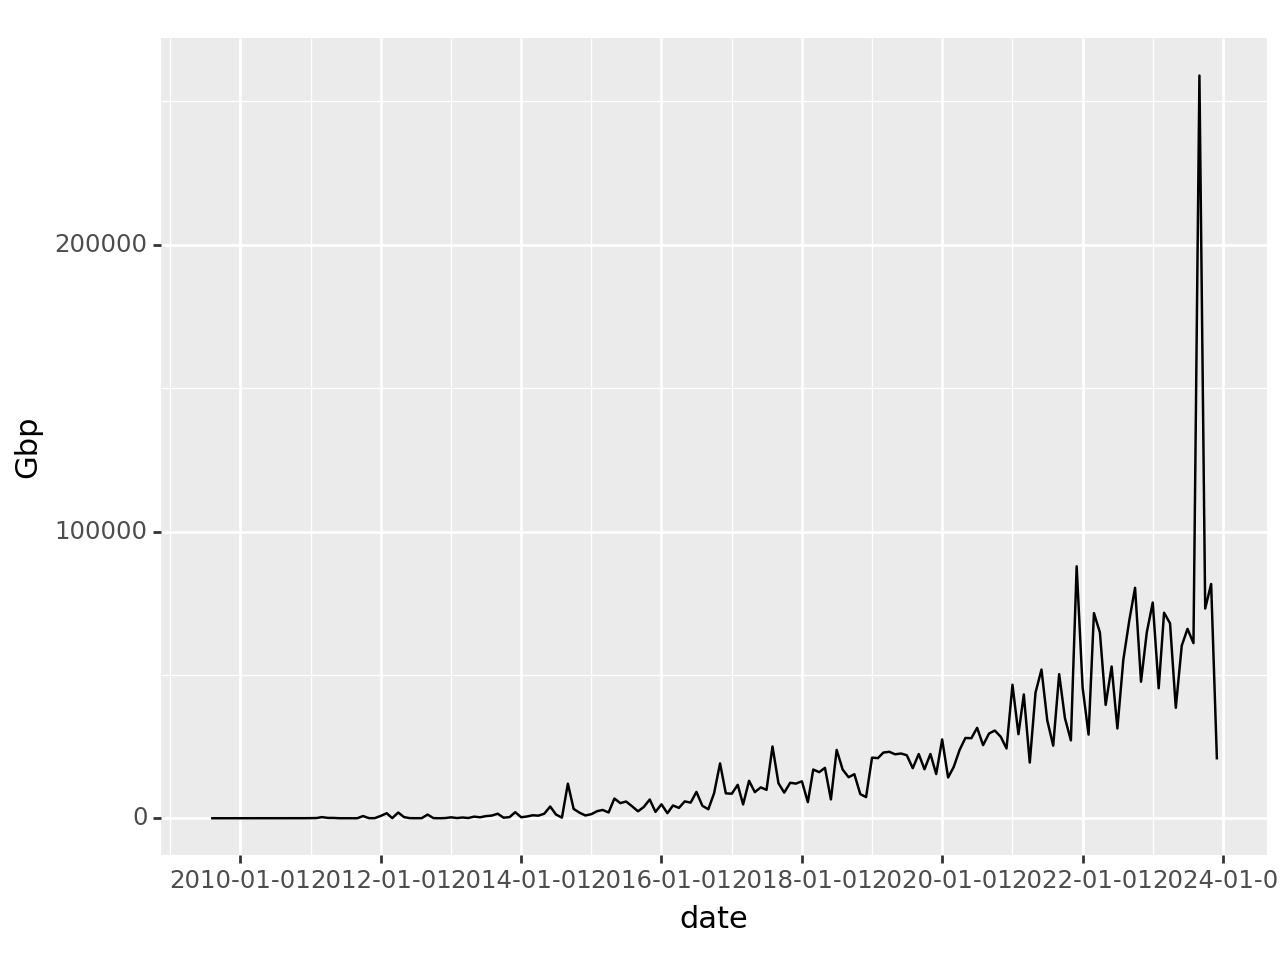

<Figure Size: (640 x 480)>

In [8]:
ggplot(per_month, aes(x='date', y='Gbp'))+geom_line() #+geom_smooth(colour='blue')

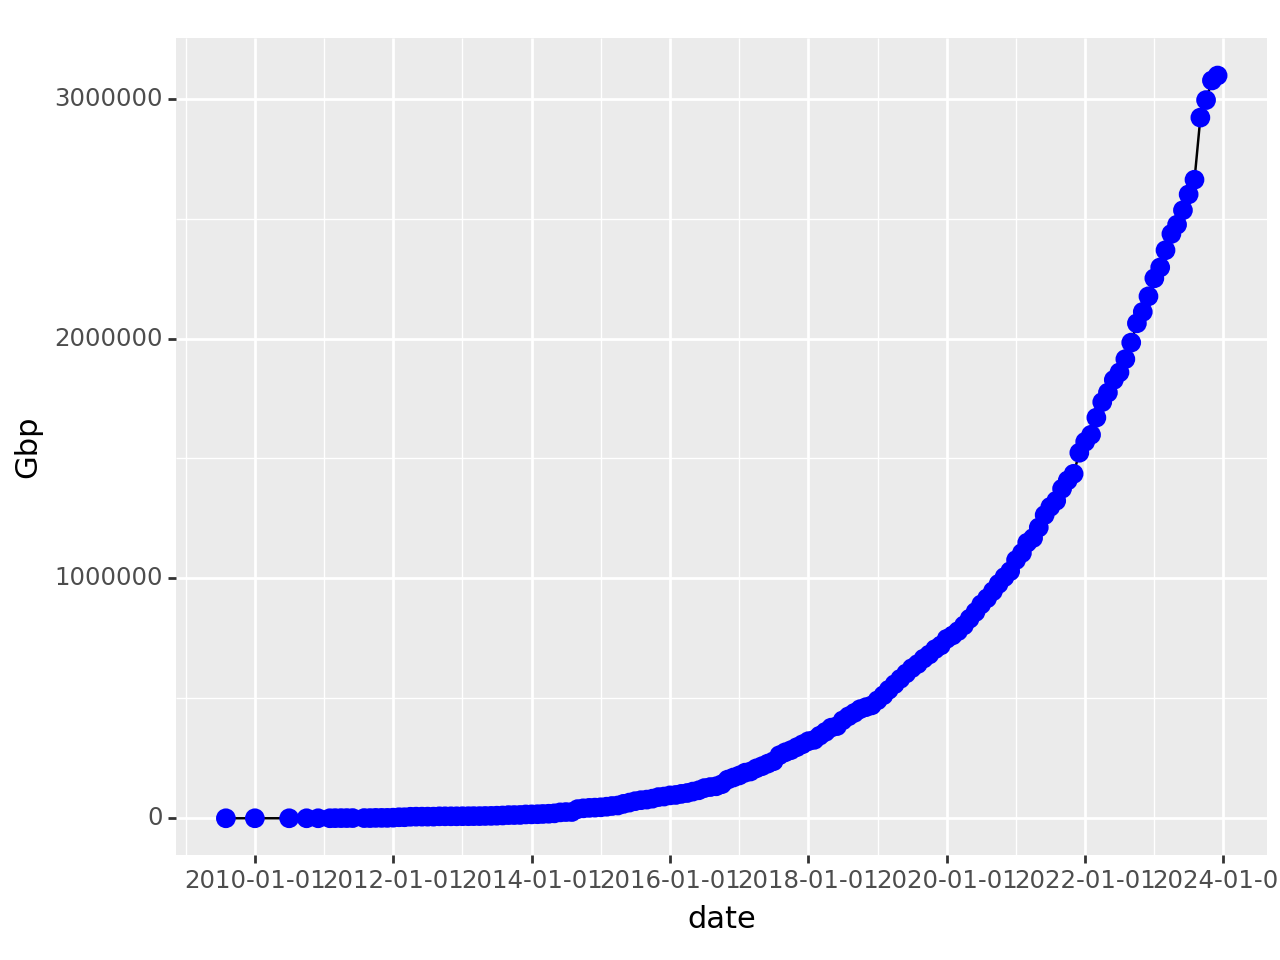

<Figure Size: (640 x 480)>

In [9]:
perm_month_cumulative = per_month.sort('date').with_columns(pl.col('Gbp').cumsum())
ggplot(perm_month_cumulative, aes(x='date', y='Gbp'))+geom_line()+geom_point(size=3, colour='blue') #+geom_smooth(colour='blue')

/home/ben/e/mybase/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



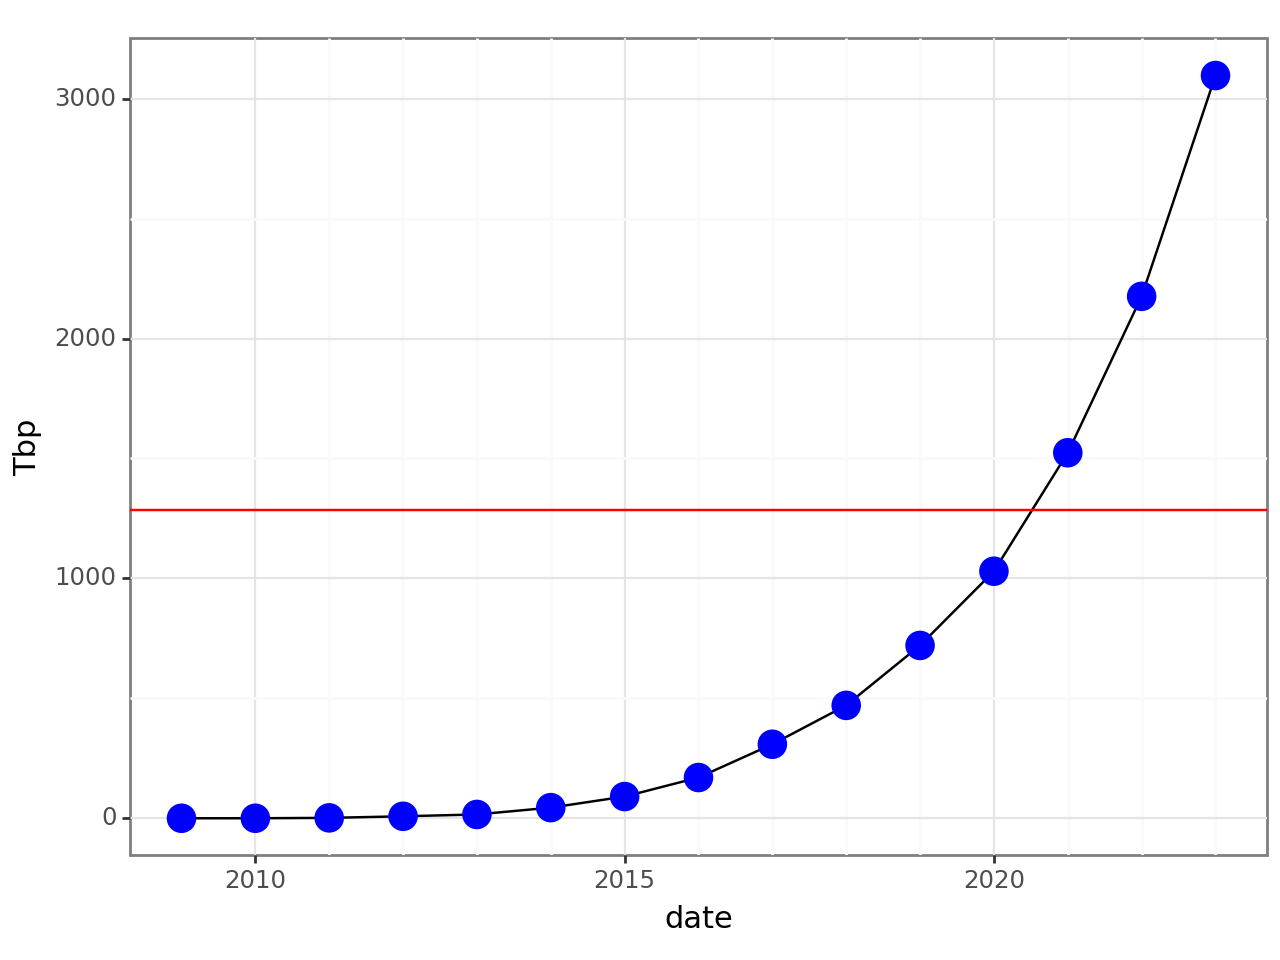

<Figure Size: (640 x 480)>

In [10]:
per_year = df.with_columns(pl.col('releasedate').dt.year().alias('date')).groupby('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
perm_year_cumulative = per_year.sort('date').with_columns(pl.col('Gbp').cumsum())
perm_year_cumulative = perm_year_cumulative.with_columns((pl.col('Gbp') / 1000).alias('Tbp'))
ggplot(perm_year_cumulative, aes(x='date', y='Tbp'))+geom_line()+geom_point(size=5, colour='blue')+xlim([2012,max(per_year['date'])])+theme_bw()+geom_hline(yintercept=1287,colour='red')+scale_x_continuous(
    breaks=range(2010,max(per_year['date'])+1,5),
    minor_breaks=range(2010,max(per_year['date'])+1,1))

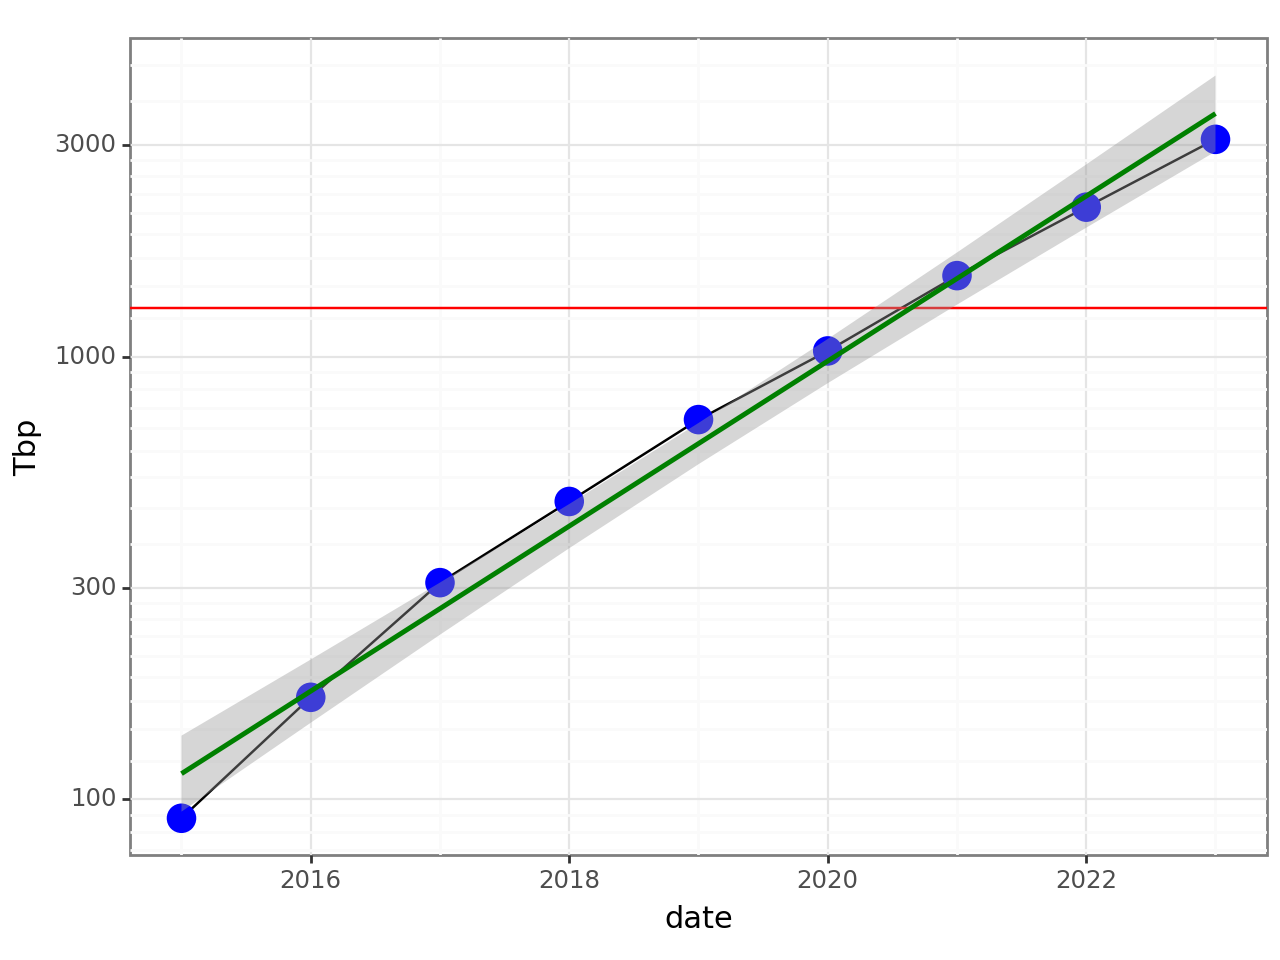

<Figure Size: (640 x 480)>

In [11]:
per_year = df.with_columns(pl.col('releasedate').dt.year().alias('date')).groupby('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
perm_year_cumulative = per_year.sort('date').with_columns(pl.col('Gbp').cumsum())
perm_year_cumulative = perm_year_cumulative.with_columns((pl.col('Gbp') / 1000).alias('Tbp'))
ggplot(perm_year_cumulative.filter(pl.col('date')>2014), aes(x='date', y='Tbp'))+geom_line()+geom_point(size=5, colour='blue')+theme_bw()+geom_hline(yintercept=1287,colour='red')+scale_x_continuous(
    # breaks=range(2010,max(per_year['date'])+1,5),
    # minor_breaks=range(2010,max(per_year['date'])+1,1)
    )+scale_y_log10()+geom_smooth(method='lm', colour='green')